## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10,
              num_neurons=[512, 256, 128],
              l2_ratio=1e-4, drp_ratio=0.2):
    """Code Here
    建立你的神經網路
    """

    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])


    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
Dropout_EXP = 0.25

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio, drp_ratio=Dropout_EXP)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 

50000/50000 [==============================] - 7s 148us/step - loss: 1.6798 - accuracy: 0.4437 - val_loss: 1.7065 - val_accuracy: 0.4290
Epoch 44/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.6707 - accuracy: 0.4407 - val_loss: 1.6721 - val_accuracy: 0.4339
Epoch 45/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.6684 - accuracy: 0.4460 - val_loss: 1.6907 - val_accuracy: 0.4295
Epoch 46/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.6768 - accuracy: 0.4408 - val_loss: 1.6253 - val_accuracy: 0.4536
Epoch 47/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.6602 - accuracy: 0.4470 - val_loss: 1.7136 - val_accuracy: 0.4263
Epoch 48/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.6566 - accuracy: 0.4484 - val_loss: 1.6382 - val_accuracy: 0.4537
Epoch 49/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.6622 - accuracy: 0.4443 - val_loss:

50000/50000 [==============================] - 8s 155us/step - loss: 1.5244 - accuracy: 0.5020 - val_loss: 1.5027 - val_accuracy: 0.5074
Epoch 36/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.5207 - accuracy: 0.5016 - val_loss: 1.5742 - val_accuracy: 0.4902
Epoch 37/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.5207 - accuracy: 0.5019 - val_loss: 1.5338 - val_accuracy: 0.4971
Epoch 38/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.5227 - accuracy: 0.4998 - val_loss: 1.5499 - val_accuracy: 0.4959
Epoch 39/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.5124 - accuracy: 0.5061 - val_loss: 1.5354 - val_accuracy: 0.4984
Epoch 40/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.5077 - accuracy: 0.5052 - val_loss: 1.5443 - val_accuracy: 0.4949
Epoch 41/50
50000/50000 [==============================] - 8s 166us/step - loss: 1.5064 - accuracy: 0.5075 - val_loss:

50000/50000 [==============================] - 9s 171us/step - loss: 1.4346 - accuracy: 0.4863 - val_loss: 1.3836 - val_accuracy: 0.5000
Epoch 28/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.4212 - accuracy: 0.4896 - val_loss: 1.3868 - val_accuracy: 0.4989
Epoch 29/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.4184 - accuracy: 0.4916 - val_loss: 1.4107 - val_accuracy: 0.4923
Epoch 30/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.4093 - accuracy: 0.4982 - val_loss: 1.3929 - val_accuracy: 0.4996
Epoch 31/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.4064 - accuracy: 0.4936 - val_loss: 1.4081 - val_accuracy: 0.4958
Epoch 32/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.3853 - accuracy: 0.5031 - val_loss: 1.3887 - val_accuracy: 0.4928
Epoch 33/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.3803 - accuracy: 0.5064 - val_loss:

50000/50000 [==============================] - 8s 167us/step - loss: 1.4963 - accuracy: 0.4613 - val_loss: 1.4500 - val_accuracy: 0.4780
Epoch 20/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.4912 - accuracy: 0.4664 - val_loss: 1.4265 - val_accuracy: 0.4906
Epoch 21/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.4831 - accuracy: 0.4664 - val_loss: 1.4118 - val_accuracy: 0.4957
Epoch 22/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.4756 - accuracy: 0.4695 - val_loss: 1.4415 - val_accuracy: 0.4808
Epoch 23/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.4610 - accuracy: 0.4770 - val_loss: 1.4203 - val_accuracy: 0.4941
Epoch 24/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.4556 - accuracy: 0.4774 - val_loss: 1.4281 - val_accuracy: 0.4926
Epoch 25/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.4469 - accuracy: 0.4790 - val_loss:

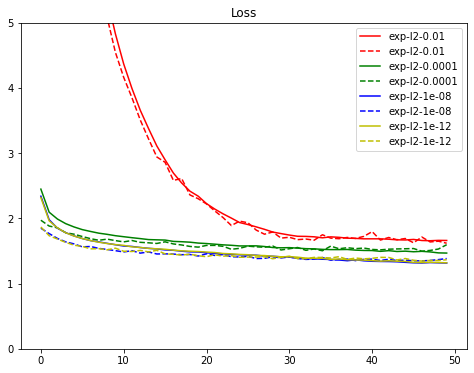

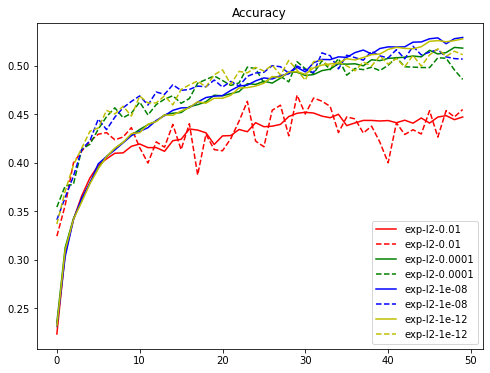

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()